In [1]:
import os
import subprocess
from cellpose import models, io
from glob import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
def crop_roi(path_img, path_mask, path_outdir, size=80):
    #画像の読み込み
    cv2_img = cv2.imread(path_img)
    cv2_mask = cv2.imread(path_mask, cv2.IMREAD_UNCHANGED)
    lower_limit = 1
    upper_limit = 255
    for threshold in range(lower_limit, upper_limit):
        mask = cv2.inRange(cv2_mask, threshold, threshold)
        if mask.sum() == 0:
            continue
        else:
            binary_image = mask.astype(np.uint8)
            contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for index, contour in enumerate(contours):
                # # ROIを作成
                # x, y, w, h = cv2.boundingRect(contour)
                # roi = cv2_img[y:y+h, x:x+w]

                # ROIの重心を計算
                # 輪郭が存在するか確認
                M = cv2.moments(contour)
                if M['m00'] == 0:
                    continue    
                else:
                    cx = int(M['m10'] / M['m00'])
                    cy = int(M['m01'] / M['m00'])

                # 重心から+/- 100 ピクセルの正方形領域を切り抜く
                size = size
                height, width, _ = cv2_img.shape
                crop_region = cv2_img[max(0, cy-size):min(cy+size, height), max(0, cx-size):min(cx+size, width)]
                

                
                # 切り抜いた領域を保存などの処理
                basename_img = os.path.basename(path_img).split(".")[0]
                output_path = "crop_"+ str(basename_img) +"_"+ str(threshold) +"_"+ str(index) + "_crop_region.tif"
                cv2.imwrite(os.path.join(path_outdir, output_path), crop_region)
                print("Cropped image is:", output_path)
                
                # gray scaleの画像も保存する
                cv2_img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
                crop_region_gray = cv2_img_gray[max(0, cy-size):min(cy+size, height), max(0, cx-size):min(cx+size, width)]
                output_path_gray = "crop_"+ str(basename_img) +"_"+ str(threshold) +"_"+ str(index) + "_crop_region_gray.tif"
                cv2.imwrite(os.path.join(path_outdir, output_path_gray), crop_region_gray)
                print("Cropped gray image is:", output_path_gray)

In [214]:
path_to_indir =  "/mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project000_YSIY1475_with-IAA-at6hr"

# path_to_model = "cyto"
model_path = "/mnt/d/200_GitHub_Repository/cellpose_segmentation/CP_20231220_180112_segspo"
model = models.CellposeModel(pretrained_model=model_path, gpu=True)

param_imgfil = "_ch01"

In [159]:
imgs = []
path_to_indir = path_to_indir
list_of_imgs = glob(os.path.join(path_to_indir, "*_ch01.tif"))
list_of_imgs.sort()
num_of_imgs = len(list_of_imgs)

for img_path in list_of_imgs:
    imgs.append(io.imread(filename=img_path))
    
    
result = model.eval(x=imgs,
                    diameter=120,
                    channels=[0, 0],)

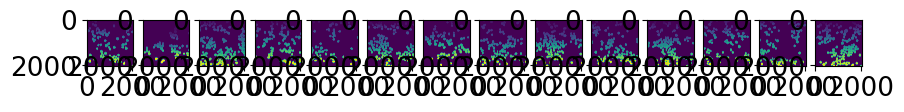

In [160]:
fig, axs = plt.subplots(1,num_of_imgs, figsize=(10,10))
plt.rcParams["font.size"] =19
for i in range(num_of_imgs):
    axs[i].imshow(result[0][i])

In [161]:
for i in range(num_of_imgs):
    file_name = os.path.basename(list_of_imgs[i]).split(".")[0]
    io.masks_flows_to_seg(images=imgs[i], masks=result[0][i], 
                          flows=result[1][i], 
                          diams=None, 
                          file_names=os.path.join(path_to_indir, file_name)
    )
    
    io.save_masks(images=imgs[i], masks=result[0][i],
                  flows=result[1][i], 
                  file_names = os.path.join(path_to_indir, file_name)
    )
    io.save_rois(masks=result[0][i],
                file_name = os.path.join(path_to_indir, file_name)
    )

In [162]:
# ディレクトリの中にある画像に対して、crop_roi関数を適用する
# ch02まであるのかを指定する
path_to_indir =  path_to_indir


In [163]:
#　今は手動でchを指定しているが、自動でchを指定できるようにする
list_of_imgs = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9]_[0-9][0-9][0-9]min_ch01.tif"))

list_of_imgs.sort()
for index, imgs in enumerate(list_of_imgs):
    #入力画像のパスを指定
    basename_img = os.path.basename(imgs).split(".")[0]
    path_img = imgs
    ch_name = os.path.basename(imgs).split("_")[2]
    path_mask = imgs.replace(ch_name, "ch01_cp_masks.png")
    # path_mask = imgs.split(".")[0] + "_ch01_cp_masks.png"

    # 出力画像のパスを指定
    path_outdir = path_to_indir +"/crop_"+ basename_img
    os.makedirs(path_outdir, exist_ok=True)

    crop_roi(path_img, path_mask, path_outdir, size=80)

Cropped image is: crop_Image001_420min_ch01_1_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch01_1_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch01_2_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch01_2_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch01_3_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch01_3_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch01_4_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch01_4_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch01_5_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch01_5_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch01_6_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch01_6_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch01_7_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch01_7_0_crop_region_gray.tif
Cropped image is: crop_Image001_42

In [164]:
#　今は手動でchを指定しているが、自動でchを指定できるようにする
list_of_imgs = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9]_[0-9][0-9][0-9]min_ch00.tif"))

list_of_imgs.sort()
for index, imgs in enumerate(list_of_imgs):
    #入力画像のパスを指定
    basename_img = os.path.basename(imgs).split(".")[0]
    path_img = imgs
    ch_name = os.path.basename(imgs).split("_")[2]
    path_mask = imgs.replace(ch_name, "ch01_cp_masks.png")
    # path_mask = imgs.split(".")[0] + "_ch01_cp_masks.png"

    # 出力画像のパスを指定
    path_outdir = path_to_indir +"/crop_"+ basename_img
    os.makedirs(path_outdir, exist_ok=True)

    crop_roi(path_img, path_mask, path_outdir, size=80)

Cropped image is: crop_Image001_420min_ch00_1_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch00_1_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch00_2_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch00_2_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch00_3_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch00_3_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch00_4_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch00_4_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch00_5_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch00_5_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch00_6_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch00_6_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_ch00_7_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_ch00_7_0_crop_region_gray.tif
Cropped image is: crop_Image001_42

In [165]:
#　今は手動でchを指定しているが、自動でchを指定できるようにする
list_of_imgs = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9]_[0-9][0-9][0-9]min.tif"))

list_of_imgs.sort()
for index, imgs in enumerate(list_of_imgs):
    #入力画像のパスを指定
    basename_img = os.path.basename(imgs).split(".")[0]
    path_img = imgs
    ch_name = os.path.basename(imgs).split("_")[1]
    # path_mask = imgs.replace(ch_name, "ch01_cp_masks.png")
    path_mask = imgs.split(".")[0] + "_ch01_cp_masks.png"

    # 出力画像のパスを指定
    path_outdir = path_to_indir +"/crop_"+ basename_img
    os.makedirs(path_outdir, exist_ok=True)

    crop_roi(path_img, path_mask, path_outdir, size=80)

Cropped image is: crop_Image001_420min_1_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_1_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_2_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_2_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_3_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_3_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_4_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_4_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_5_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_5_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_6_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_6_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_7_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_7_0_crop_region_gray.tif
Cropped image is: crop_Image001_420min_8_0_crop_region.tif
Cropped gray image is: crop_Image001_420min_8

In [166]:
# #　今は手動でchを指定しているが、自動でchを指定できるようにする
# list_of_imgs = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9]_ch01.tif"))

# list_of_imgs.sort()
# for index, imgs in enumerate(list_of_imgs):
#     #入力画像のパスを指定
#     basename_img = os.path.basename(imgs).split(".")[0]
#     path_img = imgs
#     ch_name = os.path.basename(imgs).split("_")[1]
#     path_mask = imgs.replace(ch_name, "ch02_cp_masks.png")
#     # path_mask = imgs.split(".")[0] + "_ch02_cp_masks.png"

#     # 出力画像のパスを指定
#     path_outdir = path_to_indir +"/crop_"+ basename_img
#     os.makedirs(path_outdir, exist_ok=True)

#     crop_roi(path_img, path_mask, path_outdir, size=80)

In [167]:

# #　今は手動でchを指定しているが、自動でchを指定できるようにする
# list_of_imgs = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9]_ch02.tif"))

# list_of_imgs.sort()
# for index, imgs in enumerate(list_of_imgs):
#     #入力画像のパスを指定
#     basename_img = os.path.basename(imgs).split(".")[0]
#     path_img = imgs
#     ch_name = os.path.basename(imgs).split("_")[1]
#     path_mask = imgs.replace(ch_name, "ch02_cp_masks.png")
#     # path_mask = imgs.split(".")[0] + "_ch02_cp_masks.png"

#     # 出力画像のパスを指定
#     path_outdir = path_to_indir +"/crop_"+ basename_img
#     os.makedirs(path_outdir, exist_ok=True)

#     crop_roi(path_img, path_mask, path_outdir, size=80)


In [168]:
# #　今は手動でchを指定しているが、自動でchを指定できるようにする
# list_of_imgs = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9]_ch00.tif"))

# list_of_imgs.sort()
# for index, imgs in enumerate(list_of_imgs):
#     #入力画像のパスを指定
#     basename_img = os.path.basename(imgs).split(".")[0]
#     path_img = imgs
#     ch_name = os.path.basename(imgs).split("_")[1]
#     path_mask = imgs.replace(ch_name, "ch02_cp_masks.png")
#     # path_mask = imgs.split(".")[0] + "_ch02_cp_masks.png"

#     # 出力画像のパスを指定
#     path_outdir = path_to_indir +"/crop_"+ basename_img
#     os.makedirs(path_outdir, exist_ok=True)

#     crop_roi(path_img, path_mask, path_outdir, size=80)


In [169]:
# #　今は手動でchを指定しているが、自動でchを指定できるようにする
# list_of_imgs = glob(os.path.join(path_to_indir, "Image[0-9][0-9][0-9].tif"))

# list_of_imgs.sort()
# for index, imgs in enumerate(list_of_imgs):
#     #入力画像のパスを指定
#     basename_img = os.path.basename(imgs).split(".")[0]
#     path_img = imgs
#     # ch_name = os.path.basename(imgs).split("_")[1]
#     # path_mask = imgs.replace(ch_name, "ch02_cp_masks.png")
#     path_mask = imgs.split(".")[0] + "_ch02_cp_masks.png"

#     # 出力画像のパスを指定
#     path_outdir = path_to_indir +"/crop_"+ basename_img
#     os.makedirs(path_outdir, exist_ok=True)

#     crop_roi(path_img, path_mask, path_outdir, size=80)


In [215]:
# minのリストを作成する
list_of_mins = []
list_of_imgs = glob(os.path.join(path_to_indir, "*_ch01.tif"))
list_of_mins = list(set(os.path.basename(img).split(".")[0].split("_")[1] for img in list_of_imgs))

for i_min in range(len(list_of_mins)):
    spotime = list_of_mins[i_min]
    list_of_minch01 = glob(os.path.join(path_to_indir, "*_"+ spotime +"min_ch01.tif"))
    list_of_minch01.sort()
    
    list_all_imgs = glob(os.path.join(path_to_indir, "*_ch00.tif"))
    list_of_spotime = [x for x in list_all_imgs if spotime in x]
    list_of_spotime.sort()
    # マスクになる画像を抽出する
    list_of_mask = list_of_spotime[0:int(len(list_of_spotime) / 2)]
    list_of_mask.sort()
    # 蛍光画像を抽出する
    list_of_fluo = list_of_spotime[int(len(list_of_spotime) / 2):]
    list_of_fluo.sort()
    
    for index, imgs in enumerate(list_of_fluo):
        #入力画像のパスを指定
        basename_img = os.path.basename(imgs).split(".")[0]
        path_img = imgs
        ch_name = os.path.basename(imgs).split("_")[-1]
        path_mask = list_of_mask[index].replace(ch_name, "ch01_cp_masks.png")
        # path_mask = imgs.split(".")[0] + "_ch01_cp_masks.png"

        # 出力画像のパスを指定
        path_outdir = path_to_indir +"/crop_"+ basename_img
        os.makedirs(path_outdir, exist_ok=True)

        crop_roi(path_img, path_mask, path_outdir, size=80)

Cropped image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_1_0_crop_region.tif
Cropped gray image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_1_0_crop_region_gray.tif
Cropped image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_2_0_crop_region.tif
Cropped gray image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_2_0_crop_region_gray.tif
Cropped image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_3_0_crop_region.tif
Cropped gray image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_3_0_crop_region_gray.tif
Cropped image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_4_0_crop_region.tif
Cropped gray image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_4_0_crop_region_gray.tif
Cropped image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_5_0_crop_region.tif
Cropped gray image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_5_0_crop_region_gray.tif
Cropped image is: crop_Series002_420min_Lng_SVCC_Processed001_ch00_6_0_crop_regi